# Introduction to Authentication using Behavioral Biometrics

This jupyter notebook is part of the [Introduction to Authentication using Behavioral Biometrics](https://behavioral-biometrics.org/). Please check the website for further information, in addition to the other course materials.

## Case-Study on Virtual Reality Behavioral Biometrics

This notebook handles an excerpt of the dataset of the publication "Understanding User Identification in Virtual Reality Through Behavioral Biometrics and the Effect of Body Normalization". The original paper can be retrieved [here](https://www.hci.wiwi.uni-due.de/fileadmin/fileupload/I-HCI/Paper/Understanding_User_Identification_in_Virtual_Reality_Through_Behavioral_Biometrics_and_the_Effect_of_Body_Normalization.pdf) and the dataset can be obtained from the [web](https://www.hci.wiwi.uni-due.de/en/publikationen/understanding-user-identification-in-virtual-reality-through-behavioral-biometrics-and-the-effect-of-body-normalization/).

We hold this notebook deliberately simple. This means, that we focus mostly on standard constructs of the Python programming language. Particularly, we try to avoid highly-dense numpy and pandas code, which is highly performant, but may limit understanding due to its density. Therefore, some of the loops might have a technical drawback, but for understanding the workflow, we believe that they are beneficial.

## Overview

This notebook implements three parts:
1. Enrolment, data vizualization and data inspection,
2. A feature-preprocessing based on aggregate functions, and 
3. A closed-set identification system.

Additionally, this notebook implements functions to understand and explore the data through descriptive statistics and visualizations.

In [ ]:
use_backup_dataset = False

In [ ]:
import sys
print('Your python version is:', sys.version)

Your python version is: 3.9.16 (main, Dec  7 2022, 01:11:51) 
[GCC 9.4.0]


### Enrolment

In the enrolment phase, we first load the dataset from the internet and store it in memory. We access a pre-defined json that is available for this course on the web and load it into a pandas dataframe.

In [ ]:
import pandas as pd
if use_backup_dataset:
  dataset_df = pd.read_json("https://archery23.hcigroup.de/select-bak.php")
else:
  dataset_df = pd.read_json("https://archery23.hcigroup.de/select.php")
print(f"Dataset of shape {dataset_df.shape} (num_rows, num_columns) loaded.")

Dataset of shape (136619, 29) (num_rows, num_columns) loaded.


The dataset has the following columns:

In [ ]:
dataset_df.columns

Index(['participant_ID', 'session_ID', 'timestamp', 'CenterPos_x',
       'CenterPos_y', 'CenterPos_z', 'CenterEuler_x', 'CenterEuler_y',
       'CenterEuler_z', 'LeftPos_x', 'LeftPos_y', 'LeftPos_z', 'LeftEuler_x',
       'LeftEuler_y', 'LeftEuler_z', 'RightPos_x', 'RightPos_y', 'RightPos_z',
       'RightEuler_x', 'RightEuler_y', 'RightEuler_z', 'ArrowPos_x',
       'ArrowPos_y', 'ArrowPos_z', 'ArrowEuler_x', 'ArrowEuler_y',
       'ArrowEuler_z', 'ArrowsShot', 'phase'],
      dtype='object')

We see many columns:

*   All the columns that start with `Center` are related to the center-piece of the head-mounted display (HMD), i.e., the head-piece.
*   All the columns that start with either `Left` or `Right` are for the left or right controller, respectively.
*   `Pos` denotes the position and `Euler` the rotation. Position is in Euclidean coordinates for x, y, z, and `Euler` are angles between zero and 360.
*   The Y-axis for position is "up", i.e., pointed towards the sky.
*   `participant_ID` is the participant's identifying number, `session_ID` the ID of the session and `ArrowsShot` denotes, how many arrows this participant has shot. The three variables, in conjunction, can describe each individually shot arrow.
*   `phase` is the phase of the movement, where 0 is the very beginning, 1 starts once the arrow was attached to the bow, 2 is when the bow is drawn, and 3 is when the arrow is released. The phase therefore divides a movement into four different segments.
*   `timestamp` is an integer timestamp (unixtime) in milliseconds.

We take a brief look at the data. We can print variables by adding them in the last line of a cell.

In [ ]:
dataset_df

,participant_ID,session_ID,timestamp,CenterPos_x,CenterPos_y,CenterPos_z,CenterEuler_x,CenterEuler_y,CenterEuler_z,LeftPos_x,...,RightEuler_y,RightEuler_z,ArrowPos_x,ArrowPos_y,ArrowPos_z,ArrowEuler_x,ArrowEuler_y,ArrowEuler_z,ArrowsShot,phase
0,1,1,0,20.25676,1.779540,28.41750,356.61040,3.567948,1.085510,20.09394,...,7.694692,247.8095,19.45500,1.405000,28.30000,0.000000,0.000000,0.0000,1,0
1,1,1,4,20.25668,1.779500,28.41727,356.63100,3.536176,1.138299,20.09403,...,8.011920,247.8297,19.45500,1.405000,28.30000,0.000000,0.000000,0.0000,1,0
2,1,1,17,20.25663,1.779368,28.41704,356.65560,3.520304,1.174603,20.09409,...,7.964141,247.7815,19.45500,1.405000,28.30000,0.000000,0.000000,0.0000,1,0
3,1,1,31,20.25651,1.779355,28.41694,356.71510,3.475922,1.193502,20.09421,...,7.821554,247.8477,19.45500,1.405000,28.30000,0.000000,0.000000,0.0000,1,0
4,1,1,52,20.25639,1.779472,28.41688,356.74850,3.447501,1.221688,20.09431,...,7.737264,248.0093,19.45500,1.405000,28.30000,0.000000,0.000000,0.0000,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136614,9,2,2970,19.94994,2.040039,27.75464,11.17529,3.859560,359.098100,20.05181,...,354.950500,262.3721,20.16651,1.700598,30.13760,3.548748,3.896678,352.7410,9,3
136615,9,2,2984,19.95000,2.040177,27.75442,11.16659,3.858618,359.121200,20.05176,...,355.163900,262.5280,20.18689,1.679788,30.43685,3.968555,3.896678,352.7410,9,3
136616,9,2,2998,19.94991,2.040045,27.75440,11.16378,3.846433,359.137100,20.05160,...,355.417700,262.3729,20.20727,1.656772,30.73611,4.387935,3.896677,352.7409,9,3
136617,9,2,3011,19.95003,2.040046,27.75441,11.16046,3.851585,359.133600,20.05156,...,355.288200,262.1706,20.22086,1.640201,30.93562,4.667264,3.896678,352.7409,9,3


In [ ]:
print(f'The following headsets are in the database: {dataset_df.participant_ID.unique()}')

The following headsets are in the database: [ 1 10 11 12 13 14 15 16  2  3  4  5  6  7  8  9]


#### Visualization and Inspection

In the next section, we are going to explore the data. To do so, we visualize behavioral samples, check all sample's lengths and search for anomalies within the data.

The data consists of behavioral data in the form of spatiotemporal movement data, and a phase. The phase provides an information on the user's current interaction. For Archery, the phases are defined as following:

0. The user is standing in the world and looking around.
1. The user has grabbed an arrow from the quiver.
2. The user attached this arrow to the bow and is aiming.
3. The arrow is released and en route to the target.

##### Task 1: Checking variables

First, take a look at the values of the `dataset_df`-object. Do so, by printing it in the next cell. (Hint: in the cells above, you can already find some code to print variables.)

In [ ]:
# Task 1

# ... your solution here ...
dataset_df

,participant_ID,session_ID,timestamp,CenterPos_x,CenterPos_y,CenterPos_z,CenterEuler_x,CenterEuler_y,CenterEuler_z,LeftPos_x,...,RightEuler_y,RightEuler_z,ArrowPos_x,ArrowPos_y,ArrowPos_z,ArrowEuler_x,ArrowEuler_y,ArrowEuler_z,ArrowsShot,phase
0,1,1,0,20.25676,1.779540,28.41750,356.61040,3.567948,1.085510,20.09394,...,7.694692,247.8095,19.45500,1.405000,28.30000,0.000000,0.000000,0.0000,1,0
1,1,1,4,20.25668,1.779500,28.41727,356.63100,3.536176,1.138299,20.09403,...,8.011920,247.8297,19.45500,1.405000,28.30000,0.000000,0.000000,0.0000,1,0
2,1,1,17,20.25663,1.779368,28.41704,356.65560,3.520304,1.174603,20.09409,...,7.964141,247.7815,19.45500,1.405000,28.30000,0.000000,0.000000,0.0000,1,0
3,1,1,31,20.25651,1.779355,28.41694,356.71510,3.475922,1.193502,20.09421,...,7.821554,247.8477,19.45500,1.405000,28.30000,0.000000,0.000000,0.0000,1,0
4,1,1,52,20.25639,1.779472,28.41688,356.74850,3.447501,1.221688,20.09431,...,7.737264,248.0093,19.45500,1.405000,28.30000,0.000000,0.000000,0.0000,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136614,9,2,2970,19.94994,2.040039,27.75464,11.17529,3.859560,359.098100,20.05181,...,354.950500,262.3721,20.16651,1.700598,30.13760,3.548748,3.896678,352.7410,9,3
136615,9,2,2984,19.95000,2.040177,27.75442,11.16659,3.858618,359.121200,20.05176,...,355.163900,262.5280,20.18689,1.679788,30.43685,3.968555,3.896678,352.7410,9,3
136616,9,2,2998,19.94991,2.040045,27.75440,11.16378,3.846433,359.137100,20.05160,...,355.417700,262.3729,20.20727,1.656772,30.73611,4.387935,3.896677,352.7409,9,3
136617,9,2,3011,19.95003,2.040046,27.75441,11.16046,3.851585,359.133600,20.05156,...,355.288200,262.1706,20.22086,1.640201,30.93562,4.667264,3.896678,352.7409,9,3


##### Task 2: Boxplotting Height

Next, we want to understand the deviations in height. Each participant's height is denoted by the y-axis of the center piece of the HMD. Using plotly, we can easily gain insights into the different reported heights. The height of each participant can change between sessions, if they put on the HMD in an odd way, during one session, if they voluntarily crouch, or, due to general sensor noise.

Please create a boxplot in plotly using the `px.box()` function. You need four parameters. The first parameter is the dataframe. Then, the named parameter `x=` receives a column-name for the description of the x-axis. As the named `y=` parameter, we take the column-name that denotes the participants' height. Last, we can use `color=` to create color-grouped boxplots (e.g., session-wise).

Hint: The function call can look like this: `px.box(<dataframe>, x='<columnname>', y='<columnname>', color='<columnname>')`.

In [ ]:
# Task 2

import plotly.express as px

# ... your solution here ...
px.box(dataset_df, x='participant_ID', y='CenterPos_y', color='session_ID')

##### Task 3: Counting sample lengths

Next, we want to count, how many rows exist in the data for each arrow that was shot.

Each row in the dataframe corresponds to exactly one frame that was generated by the VR device. The device that was used to elicit the data sampled at 72 hz, i.e., 72 frames per second. However, some people likely took longer to shoot an arrow than others due to natural variance in behavior. Now, we want to count the frames per shot arrow so that we have a rough understanding how long each arrow-shooting interaction took.

Hint: You need to take the dataframe and group it by the three describing identifier-variables, that are related to the participant, session, and the number of shot arrows. You can look up the column names above.

To count, you can *apply* a counting function such as *len*, after you group the dataframe by the three identifier variables. Or in other words: create a list of strings that contains the three identifier-columns, use it in combination with the `.groupby()`-function and `.apply` the `len`-function then.

In [ ]:
# Task 3

# ... your solution here ...
dataset_df.groupby(['participant_ID', 'session_ID', 'ArrowsShot']).apply(len)

participant_ID  session_ID  ArrowsShot
1               1           1             422
                            2             531
                            3             563
                            4             449
                            5             423
                                         ... 
16              2           8             257
                            9             230
                            10            228
                            11            226
                            12            232
Length: 384, dtype: int64

##### Task 4: Descriptive statistics

After obtaining your result from Task 3, generate some descriptive statistics.
Identify the fastest-shot arrows according to the number of frames it took to shoot the arrow. Divide the value manually by 72. How many seconds did it take, to shoot the quickest-drawn arrow?

Hint: apply the `.describe()`-function to your result from Task 3.

In [ ]:
# Task 4

# ... your solution here ...
dataset_df.groupby(['participant_ID', 'session_ID', 'ArrowsShot']).apply(len).describe()

count     384.000000
mean      355.778646
std       195.375318
min       162.000000
25%       242.500000
50%       302.500000
75%       406.250000
max      2050.000000
dtype: float64

##### Task 5: Scatterplotting movement

The following cell has code to 3D-scatterplot spatiotemporal movements, given a `participant_ID`, a `session_ID`, and an `arrow_ID`. Create a couple of boxplots and try to find your own, odd movements, from the second archery sessions. Write down the identifiers for these movements.

In [ ]:
def visualize_sample(df: pd.DataFrame, 
                     participantID, 
                     sessionID: int, 
                     arrowID: int) -> None:
    """This function creates a spatial, 3D scatterplot, given a dataframe of
    coordinates (df) and concrete values for participantID (int or str), 
    sessionID (integer), and arrowID (integer)."""
    import plotly.express as px
    import plotly.graph_objects as go
    
    # info: in plotly, Z is the upwards axis. In Unity, Y is the upwards axis. 
    # hence, they are interchanged here. 
    fig1 = px.scatter_3d(dataset_df.loc[(dataset_df['participant_ID'] == participantID) & 
                                        (dataset_df['session_ID'] == sessionID) & 
                                        (dataset_df['ArrowsShot'] == arrowID)], 
                                        x='CenterPos_x', 
                                        y='CenterPos_z', 
                                        z='CenterPos_y',
                                        color='phase', 
                                        symbol_sequence='x')
    fig2 = px.scatter_3d(dataset_df.loc[(dataset_df['participant_ID'] == participantID) & 
                                        (dataset_df['session_ID'] == sessionID) & 
                                        (dataset_df['ArrowsShot'] == arrowID)], 
                                        x='LeftPos_x', 
                                        y='LeftPos_z', 
                                        z='LeftPos_y',
                                        color='phase', 
                                        symbol_sequence=['circle-open'])
    fig3 = px.scatter_3d(dataset_df.loc[(dataset_df['participant_ID'] == participantID) & 
                                        (dataset_df['session_ID'] == sessionID) & 
                                        (dataset_df['ArrowsShot'] == arrowID)], 
                                        x='RightPos_x', 
                                        y='RightPos_z', 
                                        z='RightPos_y',
                                        color='phase', 
                                        symbol_sequence=['circle'])
    fig4 = go.Figure(data=fig1.data + fig2.data + fig3.data)
    fig4.show()


visualize_sample(dataset_df, participantID="Quest2_4", sessionID=1, arrowID=1)

### Pre-Processing

At last, we employ a simple feature processing. For each column in each dataframe, the min, max, mean, and SD shall be calculated. This will result in four values per column. Of course, a more fancy approach could be chosen, too, or deep learning could be employed, that promises to craft the features automatically during the training process.

In [ ]:
def feature_crafting(df: pd.DataFrame) -> list:
    """Crafts features by calculating min, max, mean, and sd for each column. 
    Returns a list with four entries per column."""
    dictionaries_list = []

    unique_participant_ids = df['participant_ID'].unique()
    unique_session_ids = df['session_ID'].unique()
    unique_arrowsshot_ids = df['ArrowsShot'].unique()

    # we iterate over the identifier columns and identify each unique sample
    for p_id in unique_participant_ids:
      for s_id in unique_session_ids:
        for a_id in unique_arrowsshot_ids:
          # we select the necessar data by the respective identifier variables
          # to describe exactly one sample
          select_df = df.loc[(dataset_df['participant_ID'] == p_id) & 
                             (dataset_df['session_ID'] == s_id) & 
                             (dataset_df['ArrowsShot'] == a_id)]

          # we identify each sample by the identifier columns
          # then we calculate min, max, mean, sd for that sample
          # but only for the columns that are related to positional 
          # or rotational coordinates.
          # we add all of this information to a dictionary for easier handling.

          feature_vector = []
          for column in select_df.columns:
            if 'pos' in column.lower() or 'euler' in column.lower():
              feature_vector.append(select_df[column].min())
              feature_vector.append(select_df[column].max())
              feature_vector.append(select_df[column].mean())
              feature_vector.append(select_df[column].std())
          dictionaries_list.append({'participant': p_id,
                                    'session': s_id,
                                    'arrowsshot': a_id,
                                    'features': feature_vector})
    return dictionaries_list

data_dict_list = feature_crafting(dataset_df)

### Closed-Set Identification

In the following, we create a random forrest classifier to identify the users in a closed-set style.

The first cell contains a code that uses the first 6 shot arrows for training and the last 6 shot arrows for testing, while only using session 1 to draw the data from.

The second cell performs training with all data from session 1 and identifies people with all data from session 2.

Comparing the accuracy values, what do you find?

Accuracy is 0.9166666666666666


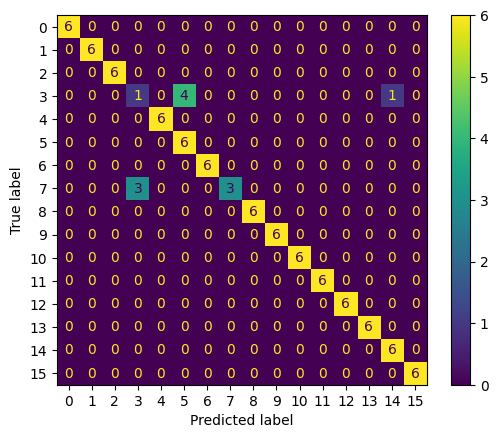

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

train_data = [d['features'] for d in data_dict_list if d['session'] == 1 and d['arrowsshot'] <= 6]
train_labels = [d['participant'] for d in data_dict_list if d['session'] == 1 and d['arrowsshot'] <= 6]

clf = RandomForestClassifier()
clf.fit(train_data, train_labels)

test_data = [d['features'] for d in data_dict_list if d['session'] == 1 and d['arrowsshot'] >= 7]
test_labels = [d['participant'] for d in data_dict_list if d['session'] == 1 and d['arrowsshot'] >= 7]
pred = clf.predict(test_data)

cm = confusion_matrix(test_labels, pred)
ConfusionMatrixDisplay(cm).plot()
acc = accuracy_score(test_labels, pred)
print('Accuracy is', acc)

Accuracy is 0.3854166666666667


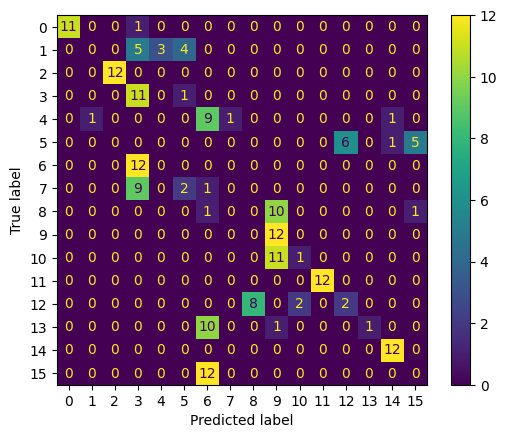

In [ ]:
train_data = [d['features'] for d in data_dict_list if d['session'] == 1]
train_labels = [d['participant'] for d in data_dict_list if d['session'] == 1]

clf = RandomForestClassifier()
clf.fit(train_data, train_labels)

test_data = [d['features'] for d in data_dict_list if d['session'] == 2]
test_labels = [d['participant'] for d in data_dict_list if d['session'] == 2]
pred = clf.predict(test_data)

cm = confusion_matrix(test_labels, pred)
ConfusionMatrixDisplay(cm).plot()
acc = accuracy_score(test_labels, pred)
print('Accuracy is', acc)

In [ ]:
print("End of notebook execution.")

End of notebook execution.
